In [1]:
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
!git clone https://github.com/spyysalo/tiny-nemotron-cc-sample/

fatal: destination path 'tiny-nemotron-cc-sample' already exists and is not an empty directory.


In [3]:
!du -h tiny-nemotron-cc-sample/data/*

2.3M	tiny-nemotron-cc-sample/data/high-actual.jsonl
700K	tiny-nemotron-cc-sample/data/high-distill.jsonl
2.0M	tiny-nemotron-cc-sample/data/high-diverse_qa_pairs.jsonl
1.3M	tiny-nemotron-cc-sample/data/high-extract_knowledge.jsonl
864K	tiny-nemotron-cc-sample/data/high-knowledge_list.jsonl
1.5M	tiny-nemotron-cc-sample/data/high-wrap_medium.jsonl
1.6M	tiny-nemotron-cc-sample/data/low-actual.jsonl
1.4M	tiny-nemotron-cc-sample/data/low-wrap_medium.jsonl
7.5M	tiny-nemotron-cc-sample/data/medium-actual.jsonl
1.6M	tiny-nemotron-cc-sample/data/medium-high-actual.jsonl
3.3M	tiny-nemotron-cc-sample/data/medium-low-actual.jsonl


In [4]:
score_files = {
    5: "tiny-nemotron-cc-sample/data/high-actual.jsonl",
    4: "tiny-nemotron-cc-sample/data/medium-high-actual.jsonl",
    3: "tiny-nemotron-cc-sample/data/medium-actual.jsonl",    
    2: "tiny-nemotron-cc-sample/data/medium-low-actual.jsonl",
    1: "tiny-nemotron-cc-sample/data/low-actual.jsonl",
}
dfs = []

for score, filename in score_files.items():
    df = pd.read_json(filename, lines=True)
    df["score"] = score
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df.head()

,text,language,warc_record_id,url,score
0,"In the autumn, falling leaves and dried-out we...",eng,ae74c0dc-785d-4c76-82e8-61ab46313f15,http://www.wcax.com/story/15369365/is-your-dog...,5
1,One of the 12 constellations introduced at the...,eng,f41502ad-88f3-4ba9-96ea-04d301175c19,http://www.ianridpath.com/startales/grus.htm,5
2,pictures,eng,0f3462fe-8fa1-47bf-8396-acb92e997f95,http://www.itshareware.com/catlist-code_157-st...,5
3,Avoid Frying When Flying: Eliminate Ionizing R...,eng,f42b4f0e-eb41-4c0a-b7d3-c615780be0f0,http://www.naturalnews.com/030425_radiation_fl...,5
4,Posts Tagged pacho galan\n\nNothing sexier in ...,eng,dcf4b10d-db43-4e6b-b7ed-d0a037f7a760,http://generationbass.com/tag/pacho-galan/,5


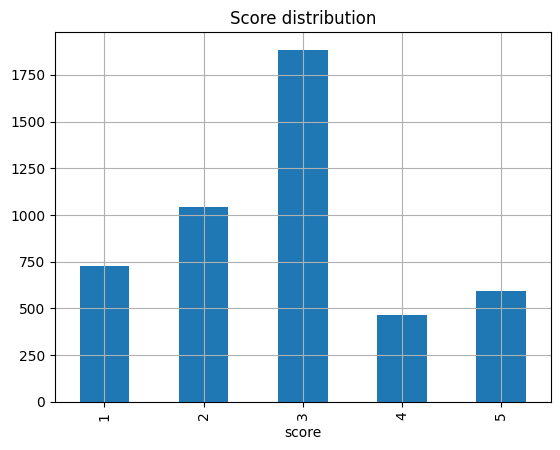

In [5]:
ax = df.score.value_counts().sort_index().plot(kind="bar")
ax.set_title("Score distribution")
ax.grid()

In [6]:
def show_given_record(i: int):
    print(f"-----{i}------")
    print(f'{df.loc[i, "text"]}')
    print(f'{df.loc[i, "url"]}')
    print(f'Score: {df.loc[i, "score"]}')

interact(show_given_record)

interactive(children=(IntText(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_given_record(i: int)>

In [7]:
# count the number of tokens
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

# Function to count tokens
def count_tokens(text):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    return len(tokens)

# Apply the function to create a new column with token counts
df['token_count'] = df['text'].apply(count_tokens)

# View the first few rows with token counts
print(df[['text', 'token_count']].head())

# Get total tokens across all rows
total_tokens = df['token_count'].sum()
print(f"Total tokens: {total_tokens}")

                                                text  token_count
0  In the autumn, falling leaves and dried-out we...          257
1  One of the 12 constellations introduced at the...          410
2                                           pictures            1
3  Avoid Frying When Flying: Eliminate Ionizing R...          707
4  Posts Tagged pacho galan\n\nNothing sexier in ...           93
Total tokens: 3450034


In [8]:
total_tokens = df.loc[df.token_count < 2000, 'token_count'].sum()
print(f"Total tokens of documents with <2K tokens: {total_tokens}")

Total tokens of documents with <2K tokens: 2096942


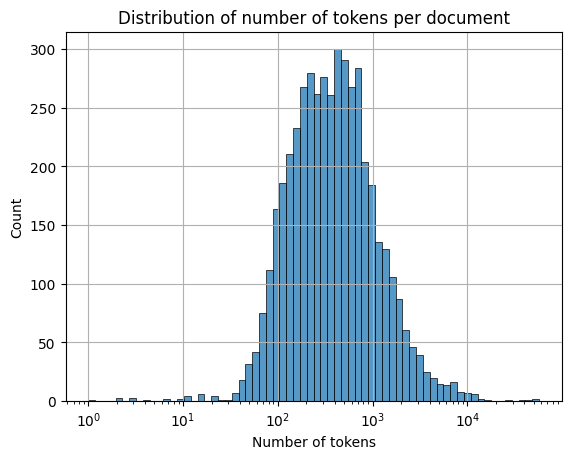

In [9]:
ax = sns.histplot(df["token_count"], log_scale=True)
ax.set_title("Distribution of number of tokens per document")
ax.set_xlabel("Number of tokens")
ax.grid()

In [10]:
price_per_1M_token = 0.18  # 8B-turbo
#price_per_1M_token = 0.88  # 70B-turbo
print(f"Expected price: {total_tokens * price_per_1M_token * 1e-6}")

Expected price: 0.37744955999999996


# Test document quality judge

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_together import ChatTogether
from langchain_community.cache import SQLiteCache
from langchain_core.globals import set_llm_cache

set_llm_cache(SQLiteCache(database_path=".langchain.db"))

model = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
chat_model = ChatTogether(model=model)

In [12]:
# Prompt from SmolLM2 https://arxiv.org/pdf/2502.02737 Appendix C.3
system_template = "You are a smart assistant helping to measure the quality of text."
prompt_analysis = '''\
Evaluate the following text extract for its potential usefulness for studying mathematics up to high school and early undergraduate levels. Use the following 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:

- Add 1 point if the extract contains some mathematical content, even if it's not very useful for studying, or if it contains non-academic content such as advertisements and generated pages for converting weight and currencies.
- Add another point if the extract touches on mathematical topics, even if it's poorly written if it's too complex such as an academic paper that is too advanced.
- Award a third point if the extract demonstrates problem solving or logical reasoning in a mathematical context, even if it lacks step-by-step explanations.
- Grant a fourth point if the extract is at an appropriate level (up to high school and early undergraduate levels) and contains clear mathematical deductions and step-by-step solutions to mathematical problems. It should be similar to a chapter from a textbook or a tutorial.
- Give a fifth point if the extract is outstanding in its educational value for teaching and studying mathematics in middle school and high school. It should include very detailed and easy to follow explanations.

Question-answer formats (e.g., from educational websites or forums) are acceptable if they meet the criteria.

The text extract:
{prompt}

After examining the extract:
- Briefly justify your total score, up to 100 words.
- Conclude with the score using the format: Final score: <total points>.
'''
print(prompt_analysis)

Evaluate the following text extract for its potential usefulness for studying mathematics up to high school and early undergraduate levels. Use the following 5-point scoring system described below. Points are accumulated based on the satisfaction of each criterion:

- Add 1 point if the extract contains some mathematical content, even if it's not very useful for studying, or if it contains non-academic content such as advertisements and generated pages for converting weight and currencies.
- Add another point if the extract touches on mathematical topics, even if it's poorly written if it's too complex such as an academic paper that is too advanced.
- Award a third point if the extract demonstrates problem solving or logical reasoning in a mathematical context, even if it lacks step-by-step explanations.
- Grant a fourth point if the extract is at an appropriate level (up to high school and early undergraduate levels) and contains clear mathematical deductions and step-by-step solution

In [13]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_template), 
    ("user", prompt_analysis)]
)
#print(prompt.messages[1].content)

In [14]:
#prompt_example = prompt_template.invoke({"prompt": "The European Union decided to fund a large project to train an LLM."})
#print(prompt_example.messages[1].content)

In [15]:
text = "The European Union decided to fund a large project to train an LLM."
prompt_templated = prompt_template.invoke({"prompt": text})
res = chat_model.invoke(prompt_templated)
completion = res.content
print(completion)
print(f'\n---\nText:{text}')

After examining the text extract, I found that it contains some non-academic content (1 point) as it appears to be a snippet of a news article or a discussion about a project. However, it does not touch on any mathematical topics (0 points), demonstrate problem solving or logical reasoning (0 points), contain clear mathematical deductions and step-by-step solutions (0 points), or provide detailed and easy-to-follow explanations (0 points).

Justification: The text extract is not related to mathematics and does not provide any educational value for studying mathematics up to high school and early undergraduate levels.

Final score: 1.

---
Text:The European Union decided to fund a large project to train an LLM.


In [16]:
# Run the scorer on a given document
i = 1
prompt_templated = prompt_template.invoke({"prompt": df.loc[i, "text"]})
res = chat_model.invoke(prompt_templated)
completion = res.content
print(completion)
print(f'\n---\nText:{df.loc[i, "text"]}')

After examining the text extract, I found that it contains some mathematical content, specifically the mention of the brightest star's magnitude (second magnitude) and the use of astronomical coordinates (e.g., Piscis Austrinus). However, the extract does not touch on mathematical topics relevant to high school and early undergraduate levels. It also does not demonstrate problem-solving or logical reasoning in a mathematical context. The extract is written in a historical and descriptive style, focusing on the constellation Grus and its associations. It does not contain clear mathematical deductions or step-by-step solutions to mathematical problems.

The extract is not at an appropriate level for studying mathematics up to high school and early undergraduate levels, and it lacks detailed explanations. However, it does provide some interesting historical and cultural information about the constellation Grus.

Final score: 1.

---
Text:One of the 12 constellations introduced at the end 

In [17]:
import re
def extract_score(completion: str):
    # Look for "Final score:" followed by optional whitespace and an integer
    match = re.search(r'Final score:\s*(\d+)', completion)    
    if match:
        return int(np.clip(int(match.group(1)), 0, 5))
    else:
        return None
        
def llm_score(text: str):
    prompt_templated = prompt_template.invoke({"prompt": text})
    res = chat_model.invoke(prompt_templated)
    return extract_score(res.content)
llm_score(text)

1

# Run document quality judge on corpus

In [18]:
df

,text,language,warc_record_id,url,score,token_count
0,"In the autumn, falling leaves and dried-out we...",eng,ae74c0dc-785d-4c76-82e8-61ab46313f15,http://www.wcax.com/story/15369365/is-your-dog...,5,257
1,One of the 12 constellations introduced at the...,eng,f41502ad-88f3-4ba9-96ea-04d301175c19,http://www.ianridpath.com/startales/grus.htm,5,410
2,pictures,eng,0f3462fe-8fa1-47bf-8396-acb92e997f95,http://www.itshareware.com/catlist-code_157-st...,5,1
3,Avoid Frying When Flying: Eliminate Ionizing R...,eng,f42b4f0e-eb41-4c0a-b7d3-c615780be0f0,http://www.naturalnews.com/030425_radiation_fl...,5,707
4,Posts Tagged pacho galan\n\nNothing sexier in ...,eng,dcf4b10d-db43-4e6b-b7ed-d0a037f7a760,http://generationbass.com/tag/pacho-galan/,5,93
...,...,...,...,...,...,...
4705,Hotel Monteolivos\n\nAbout\n\nIdeally located ...,eng,fca819a1-1134-43b0-a03c-65389680267f,https://vymaps.com/HN/Hotel-Monteolivos/,1,134
4706,"Holyhead Road Chirk\n\n£50,000\n\nGuide price\...",eng,dc83575c-9be0-4d45-82c7-0501c120ba0e,https://www.denbighshirefreepress.co.uk/homes/...,1,1635
4707,scorpion punk crystal ring is the perfect acc...,eng,08605359-86d2-4df7-9257-fe669d940393,https://mavigadget.com/products/scorpion-punk-...,1,68
4708,One-Page website includes a modern one-page de...,eng,dec84788-e449-4d84-b17f-1dc5e6407db1,https://leadgen-digital.com.au/,1,540


In [19]:
import random
random.seed(0)


random.seed(0)

df_shuffle = df.sample(frac=1, replace=False, random_state=0).copy()

n_draws = 50
score = 5

# For every score:
# 1) generate subsample dataframe with score 
# 2) call LLM scorer to get completion
# 3) parse values and add to dataframe
df_scores = []
for score in [5, 4, 3, 2, 1]: 
    df_score = df_shuffle[(df_shuffle.score == score) & (df_shuffle.token_count < 2000)]
    df_score = df_score.head(n_draws)
    print(f"Eval score {score} with {len(df_score)} samples.")
    inputs = [
        prompt_template.invoke({"prompt": text}) 
        for text in df_score.loc[:, "text"].values
    ]
    completions = chat_model.batch(inputs=inputs)
    df_score["model"] = model
    df_score["llm-score"] = [extract_score(x.content) for x in completions]
    df_scores.append(df_score)

Eval score 5 with 50 samples.
Eval score 4 with 50 samples.
Eval score 3 with 50 samples.
Eval score 2 with 50 samples.
Eval score 1 with 50 samples.


In [20]:
df_scores_all = pd.concat(df_scores, ignore_index=True)

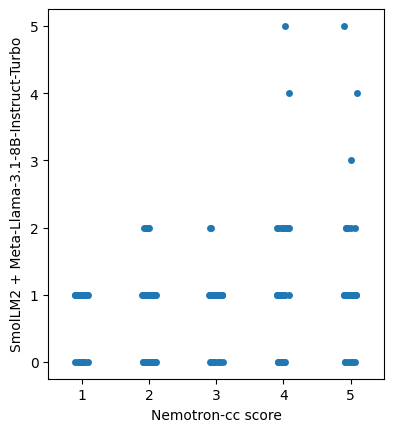

In [21]:
ax = sns.stripplot(df_scores_all, x="score", y="llm-score")
ax.set_xlabel("Nemotron-cc score")
ax.set_ylabel(f'SmolLM2 + {model.split("/")[1]}')
ax.set_aspect('equal')

In [22]:
xx = df_scores_all.sort_values(by='llm-score', ascending=False)
xx

,text,language,warc_record_id,url,score,token_count,model,llm-score
93,Category Manfre23961\n\nFuture value annuity d...,eng,c51fa0e6-fc66-446a-8e3a-7e942413196d,https://digitaloptionsgkdb.web.app/manfre23961...,4,1415,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,5
49,The Benefits of DAILY PRACTICE & REVIEW (And h...,eng,7091ac68-625d-4aa2-bdb0-a82d8d90318d,http://todayinsecondgrade.blogspot.com/2018/12...,5,1232,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,5
8,public static void main(String[] args) {\nint ...,eng,fe36fe76-d1f9-4399-9786-2f3b3ad6db0a,https://codedump.io/share/JxQPTStLdvfM/1/java-...,5,202,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,4
59,Can SAP Resources Determine if Something is Tr...,eng,a54d5762-e93a-4301-af1a-47ff98363e0d,https://www.brightworkresearch.com/can-sap-res...,4,544,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,4
40,Retinal detachment is a very serious eye condi...,eng,767d0f08-8bb4-479a-8a8d-5547da8eb0ca,http://www.webmd.com/eye-health/eye-health-ret...,5,784,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,3
...,...,...,...,...,...,...,...,...
123,"""I have a problem writing about both because o...",eng,b23c01b8-14a2-44e1-a041-d334992d64f0,https://www.f1-fansite.com/f1-news/journalists...,3,360,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,0
65,Why People Think Homes Are A Good Idea\n\nMarg...,eng,9b0a68b9-c24e-469e-8b84-a01280577c38,http://noticiasraras.info/why-people-think-hom...,4,608,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,0
68,"Monday, April 22, 2013\n\nTexmex, oil painting...",eng,81d125ca-aa77-4730-b878-9752201337a6,http://abercrombie-su.blogspot.com/2013/04/tex...,4,918,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,0
69,"Bundles\n\nWith our bundled courses, you'll be...",eng,ca5cb5d6-78fc-45c6-adaa-1f340d2c03cd,http://www.learn2serve.com/florida-alcohol-ser...,4,349,meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo,0


In [23]:
completions = chat_model.batch(inputs=[prompt_template.invoke({"prompt": xx.loc[49]["text"]}) ])
completions
print(xx.loc[49]["text"])

The Benefits of DAILY PRACTICE & REVIEW (And how to implement it in your daily routine.)

Wednesday, 5 December 2018

Hi Friends,

Today in Second Grade we reviewed and practiced in ELA and MATH. I actually do this EVERYDAY. Daily practice and review is how I get my kiddies to improve in reading and number sense. It's how I ensure that all my students acquire those important base skills that help them with grade level work in ELA and MATH.

I usually try to set aside 30-45 minutes (in ELA) and 15-20 minutes (in MATH) a day for this. It may seem like a lot of time to devote to practice/review, but without basic skills students will have difficulties grasping grade level content. Just like taking time at the beginning of the year to teach behavior expectations and routine will pay off and save time later on, so will practicing and reviewing phonics, sight words, and number sense.

You might be wondering how I manage to reach all levels during practice/review. There is a lot of differenti